In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, classification_report

import itertools
%matplotlib inline
sns.set()

In [62]:
def standardize(data):
    from sklearn.preprocessing import StandardScaler
    # Get all numeric features
    numerical_features = []
    for feature in data.dtypes.index:
        if (data[feature].dtype != np.object):
            numerical_features.append(feature)

    data[numerical_features] = data[numerical_features].fillna(0)
    
    scaler = StandardScaler()
    data[numerical_features]= scaler.fit_transform(data[numerical_features])
    standard_data = data
    
    return standard_data

In [63]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        pass
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [64]:
# read in train, test, sample submission data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')

In [65]:
train.columns

Index(['customer_id', 'age', 'job', 'marital', 'education', 'default',
       'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration',
       'campaign', 'pdays', 'previous', 'poutcome', 'emp_var_rate',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed',
       'subscribed'],
      dtype='object')

In [66]:
train['subscribed'] = train['subscribed'].replace({1: 'Yes', 0: 'No'})

In [67]:
test.columns

Index(['customer_id', 'age', 'job', 'marital', 'education', 'default',
       'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration',
       'campaign', 'pdays', 'previous', 'poutcome', 'emp_var_rate',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed'],
      dtype='object')

In [68]:
train["source"] = 'A'
test["source"] ='B'

data = pd.concat([train, test]).reset_index(drop=True)
print(data.shape)
print(train.shape)
print(test.shape)

(41188, 23)
(28831, 23)
(12357, 22)


In [69]:
data.isna().sum()

customer_id           0
age                   0
job                   0
marital               0
education             0
default               0
housing               0
loan                  0
contact               0
month                 0
day_of_week           0
duration              0
campaign              0
pdays                 0
previous              0
poutcome              0
emp_var_rate          0
cons_price_idx        0
cons_conf_idx         0
euribor3m             0
nr_employed           0
subscribed        12357
source                0
dtype: int64

In [70]:
#data.profile_report()

In [71]:
data.drop(["customer_id"], axis=1, inplace=True)

In [72]:
#checking for unique values in the categorcal columns, to examine their entries
cat_cols = data.columns[data.dtypes == object]
for col in cat_cols:
    print(col.upper(), "column has", data[col].nunique(), "unique values:\n", data[col].value_counts())

JOB column has 12 unique values:
 admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64
MARITAL column has 4 unique values:
 married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64
EDUCATION column has 8 unique values:
 university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64
DEFAULT column has 3 unique values:
 no         32588
unknown     8597
yes            3
Name: default, dtype: int64
HOUSING column has 3 unique values:
 yes        21576
no         18622
unknown      990
Name: housing, dtype: in

## Standardize the Data

In [73]:
data = standardize(data)
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,subscribed,source
0,-1.057857,admin.,married,university.degree,no,no,no,cellular,dec,mon,...,0.195414,1.671136,failure,-1.961809,-1.490351,1.621083,-1.679109,-1.986638,No,A
1,-1.057857,technician,single,university.degree,no,no,no,telephone,may,fri,...,0.195414,-0.349494,nonexistent,-1.197935,-1.179380,-1.231034,-1.367190,-0.940281,No,A
2,0.477486,blue-collar,married,basic.6y,unknown,yes,no,telephone,may,thu,...,0.195414,-0.349494,nonexistent,0.648092,0.722722,0.886447,0.714190,0.331680,No,A
3,-0.578062,services,married,university.degree,no,no,no,cellular,may,thu,...,0.195414,1.671136,failure,-1.197935,-1.179380,-1.231034,-1.322795,-0.940281,No,A
4,-0.769980,admin.,single,high.school,no,no,no,cellular,may,fri,...,0.195414,-0.349494,nonexistent,-1.197935,-1.179380,-1.231034,-1.367190,-0.940281,No,A


In [74]:
data['source'].value_counts()

A    28831
B    12357
Name: source, dtype: int64

## Return Replaced Values

In [75]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,subscribed,source
0,-1.057857,admin.,married,university.degree,no,no,no,cellular,dec,mon,...,0.195414,1.671136,failure,-1.961809,-1.490351,1.621083,-1.679109,-1.986638,No,A
1,-1.057857,technician,single,university.degree,no,no,no,telephone,may,fri,...,0.195414,-0.349494,nonexistent,-1.197935,-1.179380,-1.231034,-1.367190,-0.940281,No,A
2,0.477486,blue-collar,married,basic.6y,unknown,yes,no,telephone,may,thu,...,0.195414,-0.349494,nonexistent,0.648092,0.722722,0.886447,0.714190,0.331680,No,A
3,-0.578062,services,married,university.degree,no,no,no,cellular,may,thu,...,0.195414,1.671136,failure,-1.197935,-1.179380,-1.231034,-1.322795,-0.940281,No,A
4,-0.769980,admin.,single,high.school,no,no,no,cellular,may,fri,...,0.195414,-0.349494,nonexistent,-1.197935,-1.179380,-1.231034,-1.367190,-0.940281,No,A


In [76]:
data['subscribed'] = data['subscribed'].replace({'Yes': 1, 'No': 0})

In [77]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,subscribed,source
0,-1.057857,admin.,married,university.degree,no,no,no,cellular,dec,mon,...,0.195414,1.671136,failure,-1.961809,-1.490351,1.621083,-1.679109,-1.986638,0.0,A
1,-1.057857,technician,single,university.degree,no,no,no,telephone,may,fri,...,0.195414,-0.349494,nonexistent,-1.197935,-1.179380,-1.231034,-1.367190,-0.940281,0.0,A
2,0.477486,blue-collar,married,basic.6y,unknown,yes,no,telephone,may,thu,...,0.195414,-0.349494,nonexistent,0.648092,0.722722,0.886447,0.714190,0.331680,0.0,A
3,-0.578062,services,married,university.degree,no,no,no,cellular,may,thu,...,0.195414,1.671136,failure,-1.197935,-1.179380,-1.231034,-1.322795,-0.940281,0.0,A
4,-0.769980,admin.,single,high.school,no,no,no,cellular,may,fri,...,0.195414,-0.349494,nonexistent,-1.197935,-1.179380,-1.231034,-1.367190,-0.940281,0.0,A


## Label Encoding

In [78]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in cat_cols:
    data[col] = le.fit_transform(data[col])
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,subscribed,source
0,-1.057857,0,1,6,0,0,0,0,2,1,...,0.195414,1.671136,0,-1.961809,-1.490351,1.621083,-1.679109,-1.986638,0,0
1,-1.057857,9,2,6,0,0,0,1,6,0,...,0.195414,-0.349494,1,-1.197935,-1.179380,-1.231034,-1.367190,-0.940281,0,0
2,0.477486,1,1,1,1,2,0,1,6,2,...,0.195414,-0.349494,1,0.648092,0.722722,0.886447,0.714190,0.331680,0,0
3,-0.578062,7,1,6,0,0,0,0,6,2,...,0.195414,1.671136,0,-1.197935,-1.179380,-1.231034,-1.322795,-0.940281,0,0
4,-0.769980,0,2,3,0,0,0,0,6,0,...,0.195414,-0.349494,1,-1.197935,-1.179380,-1.231034,-1.367190,-0.940281,0,0


In [79]:
data['source'].value_counts()

0    28831
1    12357
Name: source, dtype: int64

## Split into Train and Test DF

In [80]:
train_df = data.loc[data["source"] ==0]
test_df = data.loc[data["source"] ==1]

In [81]:
print(train_df.shape,test_df.shape)

(28831, 22) (12357, 22)


In [82]:


test_df.drop(["source", "subscribed"], axis=1, inplace=True)
train_df.drop(["source"], axis=1, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [83]:
print(data.shape)
print(train_df.shape)
print(test_df.shape)

(41188, 22)
(28831, 21)
(12357, 20)


## Split into X and y

In [86]:
train.head()

,customer_id,age,job,marital,education,default,housing,loan,contact,month,...,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,subscribed,source
0,customer_id_39075,31,admin.,married,university.degree,no,no,no,cellular,dec,...,999,1,failure,-2.97,46.3565,-23.10,1.711,5023.5,No,A
1,customer_id_34855,31,technician,single,university.degree,no,no,no,telephone,may,...,999,0,nonexistent,-1.77,46.4465,-32.34,2.252,5099.1,No,A
2,customer_id_7107,47,blue-collar,married,basic.6y,unknown,yes,no,telephone,may,...,999,0,nonexistent,1.13,46.9970,-25.48,5.862,5191.0,No,A
3,customer_id_31614,36,services,married,university.degree,no,no,no,cellular,may,...,999,1,failure,-1.77,46.4465,-32.34,2.329,5099.1,No,A
4,customer_id_34878,34,admin.,single,high.school,no,no,no,cellular,may,...,999,0,nonexistent,-1.77,46.4465,-32.34,2.252,5099.1,No,A


In [88]:
train_df['subscribed'].value_counts()

0    25580
1     3251
Name: subscribed, dtype: int64

In [89]:
y = train_df['subscribed']
X = train_df.drop(["subscribed"], axis=1)

In [90]:
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state= 1234)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((20181, 20), (20181,), (8650, 20), (8650,))

In [91]:
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import f1_score

model = LogisticRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)
print(f1_score(pred, y_test))

0.4980237154150198


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [92]:
from sklearn.tree import DecisionTreeClassifier
decisiontreemodel = DecisionTreeClassifier()

decisiontreemodel.fit(X_train, y_train)
pred = decisiontreemodel.predict(X_test)
print(f1_score(pred, y_test))

0.5107692307692308


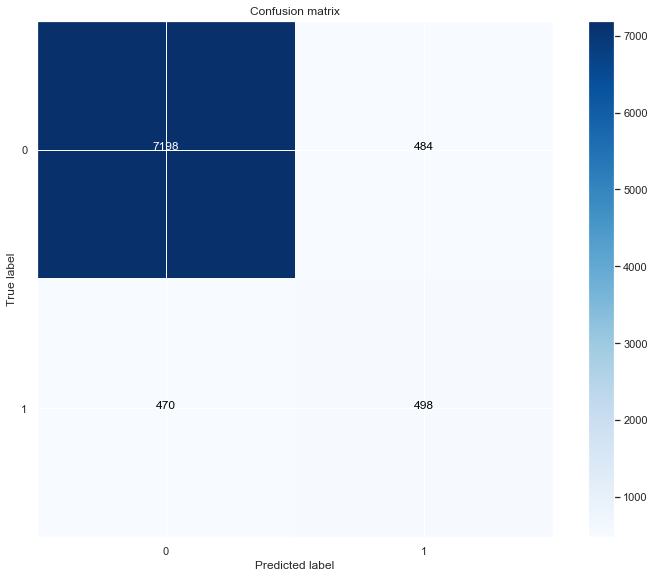

In [93]:
# plot confusion matrix
cnf_matrix = confusion_matrix(y_test,pred)
np.set_printoptions(precision=2)


class_names = [0,1]

plt.figure(figsize=(10,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
plt.show()

In [94]:
predictions = decisiontreemodel.predict(test_df)

In [95]:
predictions

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [19]:
sub.head()

,customer_id,subscribed
0,customer_id_32884,1
1,customer_id_3169,1
2,customer_id_32206,1
3,customer_id_9403,1
4,customer_id_14020,1


In [20]:
preds = pd.DataFrame({"customer_id": sub["customer_id"],"subscribed":predictions})

In [21]:
preds.to_csv("predis.csv", index=False)

from here, move on to kaggle and submit the predis.csv file 

# Standardize Values and Retry Model

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


In [30]:
sc = StandardScaler()

In [31]:
sc.fit(X_train)
X_train_std =sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [32]:
svc = SVC(kernel='linear', C=10.0, random_state = 1)
svc.fit(X_train, y_train)

SVC(C=10.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=1, shrinking=True, tol=0.001,
    verbose=False)

In [33]:
y1_pred = svc.predict(X_test)

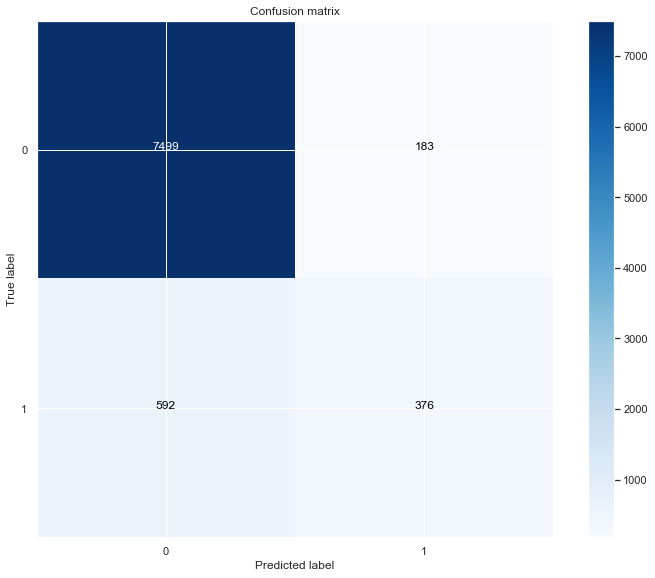

In [34]:
# plot confusion matrix
cnf_matrix = confusion_matrix(y_test,y1_pred)
np.set_printoptions(precision=2)


class_names = [0,1]

plt.figure(figsize=(10,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
plt.show()

# Rand Forest

In [96]:
model2 = RandomForestClassifier()

In [97]:
model2.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [98]:
rand_pred = model2.predict(X_test)

In [99]:
rand_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [100]:
print(f1_score(rand_pred, y_test))

0.5410917816436712


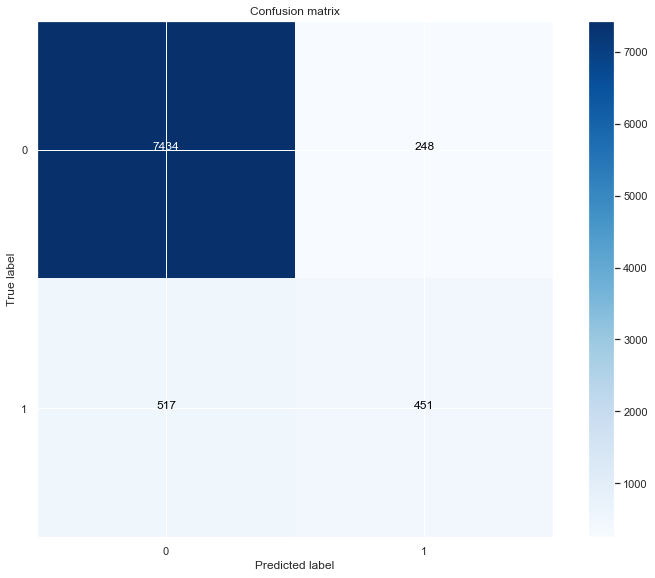

In [101]:
# plot confusion matrix
cnf_matrix = confusion_matrix(y_test,rand_pred)
np.set_printoptions(precision=2)


class_names = [0,1]

plt.figure(figsize=(10,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
plt.show()